# **Endgoal: Study Generalization Error of a Linearized Transformer architecture for in-context learning (ICL) tasks.**



# **Q. What is Transformer?**

Ans. Transformer is a NN architecture, used as the backbone of Large Language Models (LLM). What makes Transformers special in comparison to other NN architectures is a layer called the *Attention Mechanism*. This layer can store correlations between different parts of the incoming data, through matrix operations. Attention mechanism equips Transformer architectures with a capability to predict
1. missing parts of the data it has been trained on,
2. as well as missing parts of new, unseen data of similar type.

This property makes LLMs extremely efficient in learning various languages through hidden structures and syntaxes. As a result, LLMs keep showing groundbreaking performance when it comes to predicting text outputs.

****

Given below is the Transformer architecture taken from the original reference paper __[Attention is all you need](https://arxiv.org/pdf/1706.03762)__.
><div>
><img src="https://drive.google.com/uc?export=view&id=17btW9mybtoC3BkdNVXiszCruFz6x6jmO" width="400"/>
></div>

****

Pytorch has an inbuilt class called *Transformer*. One can directly call this using the code snippet ```torch.nn.Transformer```.

See __[documentation](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)__.


# **Q. What is in-context learning (ICL)?**

Ans. In a nut shell, ICL is the process of providing a prompt or “context” to a pre-trained LLM to guide its answers for a specific task. It is a specific kind of prompt engineering where the demonstrations of the task are included as part of the model. Let us understand this using a single example.

Consider a prompt made of $l+1$ tokens: a sequence $\{x_1,x_2,\cdots , x_l,x_{l+1}\}$. We want to train a Transformer architecture such that it produces outputs $\{y_1,y_2,\cdots,y_l,y_{l+1}\}$, when this input sequence is provided. ICL would require training the Transformer architecture on a subset of the input and target data $\{x_1,y_1,\cdots, x_n,y_n\}$. With that, the trained Transformer would be able to predict correct target $y_p$ for input tokens $x_p$ that were not included the training set.

# Real-life example in-context learning in LLMs:

**Inputs**
>Example 1:
>Description: This animal has a long trunk and large ears. \\
>Animal: Elephant
>
>Example 2:
>Description: This animal has a mane and is known as the king of the jungle. \\
>Animal: Lion
>
>Example 3:
>Description: This animal has black and white stripes. \\
>Animal: \\

**Expected output**
>Example 3:
>Description: This animal has black and white stripes. \\
>Animal: Zebra


# Time to build a Transformer and experiment with ICL.

**But we don't have sufficient time+compute to build a full Transformer from scratch and train it. Let's simplify the architecture.**

> # Let us build a Linearized Transformer, where the softmax structure of Attention is replaced with a linearized form.

Attention layer in Transformers are made of three matrices: key $K$, query $Q$, and value $V$.
$$\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{Q K^\top}{\sqrt{d_k}}\right)V$$

Here, $d_k$ is the dimension of the Key matrix, used to normalize the exponents within softmax function. There are several literature that explains how key, query, and values are constructed using parameter matrices for $K$, $Q$, $V$, and data $\vec{x},\vec{y}$, e.g. __[this paper](https://arxiv.org/pdf/2304.07235)__.

We will simplify life in this session by choosing a linearized form of attention layer which is shown to closely replicate the performances of actual transformers for ICL tasks, see references __[[1]](https://arxiv.org/abs/2402.14180)__, __[[2]](https://arxiv.org/abs/2306.09927)__. These results are particularly well established for last token predictions.

Let us define the task: an input sequence made of input tokens $\vec{x}_i$ and scalar targets $y_i$,
$$Z = \begin{bmatrix} x_1 & x_2 & \cdots & x_l & x_{l+1} \\ y_1 & y_2 & \cdots & y_l & 0 \end{bmatrix} \in \mathbb{R}^{(d+1)\times(l+1)}.$$
$d$ is the vector dimension of each input token, and $l$ is the number of tokens in a sequence. We will eventually consider $p$ such sequences or samples or prompts. Here $0$ is a token that prompts the target scalar $y_{l+1}$ to be predicted.  

**Define a *Linearized Attention* layer**: For arbitrarily sized parameter matrices $K$, $Q$, $V$, the output of the linearized attention layer is the following
$$\text{Linearized Attention}(Q,K,V) = Z + \frac{1}{l} V Z (K Z)^\top (QZ).$$

# **Exercise 1: Look up Pytorch documentation on matrix operations and NN parameterization (e.g. __[this](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html)__). Using this, define an architecture with a single hidden layer with the linearized attention defined above. Inputs $Z$ and Outputs $Z + \frac{1}{l} V Z (K Z)^\top (QZ)$**.


>Hint: initialize parameters in key, query, and values matrices as independent and identical Gaussian draws from $\mathbf{N}(0,1/d)$. This initialization will help to reduce divergences in Generalization Error of ICL tasks, when token dimensions grow.

>Conventions: $d$:= each token dimension, $l$:= sequence length, $p$:= sample size.

In [1]:
# importing essential libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import os
# from mpi4py import MPI
import sys

In [2]:
# importing essential libraries, part 2

import warnings
import torch.nn.functional as F
from torch.nn import Module, MultiheadAttention, ModuleList, Linear, LayerNorm
from torch.nn.init import xavier_uniform_
from torch.nn import Dropout
from typing import Optional, Union, Callable, Any
import torch.optim as optim

import matplotlib.pyplot as plt

In [ ]:
!pip install cudf-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
!rm -rf /usr/local/lib/python3.8/dist-packages/cupy*
!pip install cupy-cuda11x

In [ ]:
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/...
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash
!apt install cm-super

# **Solution:**

In [3]:
# the architecture with a single linearized attention layer is defined below.


class SingleLayerTransformer(nn.Module):
    def __init__(self, sample_size, seq_length, input_dim):
        super(SingleLayerTransformer, self).__init__()
        self.input_dim = input_dim
        # Define key, query, and values for this linear transformer
        self.K = nn.Parameter(torch.randn(input_dim + 1, input_dim + 1))  # Key matrix initialized as random Gaussian i.i.d. draws
        self.Q = nn.Parameter(torch.randn(input_dim + 1, input_dim + 1))  # Query matrix initialized as random Gaussian i.i.d. draws
        self.V = nn.Parameter(torch.randn(input_dim + 1, input_dim + 1))  # Value matrix initialized as random Gaussian i.i.d. draws

    def forward(self, Z, sample_size, seq_length, input_dim):
        N = seq_length  # we will divide by sequence length, I have labelled this as "l" in theory section

        Q = self.Q/np.sqrt(input_dim+1)  # Use the redefined query with Identity/d as covariance
        K = self.K/np.sqrt(input_dim+1)  # Use the redefined key with Identity/d as covariance
        V = self.V/np.sqrt(input_dim+1)  # Use the redefined value with Identity/d as covariance

        # we use einsum to construct the network predictor step-by-step
        pred1 = torch.einsum('de, mje -> mjd', K, Z).to('cuda') # we use the convention: sample_size, sequence_length, input_dim for every tensor's shape
        Qtrans = Q.permute(1,0) # transpose of Q
        Ztrans = Z.permute(0,2,1) # transpose of Z
        pred1 = torch.einsum('cd, mjd -> mjc', Qtrans, pred1).to('cuda') # This generates: Q^T K Z
        pred1 = torch.einsum('mci, mjc -> mij', Ztrans, pred1).to('cuda') # This generates: Z^T Q^T K Z
        pred1 = torch.einsum('mib, mij -> mjb', Z, pred1).to('cuda') # This generates: Z Z^T Q^T K Z
        pred1 = torch.einsum('ab,mjb -> mja', V, pred1).to('cuda') # This generates: V Z Z^T Q^T K Z

        ypred = Z[:,-1,-1] + pred1[:,-1,-1] # this ensures that the prediction is the last element as a scalar from Z + (VZ)(QZ)^T(KZ)/N



        return ypred


# **Exercise 2: Consider the following relation between inputs and targets $y_i := \sum_{j=1}^{d} \omega_{j}x^{j}_{i} + \epsilon_i$, where $x^j_i \sim \mathbf{N}(0,1/\sqrt{d})$, $\omega_j \sim \mathbf{N}(0,1)$ and $\epsilon_i \sim \mathbf{N}(0, 0.01)$. Using this, define a MSE or $L_2$ loss function for the Linearized Transformer. Then, write a function that (a) trains this architecture using combinations of various optimizers, e.g. __[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)__, __[SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)__, until loss falls below $10^{-10}$, and then (b) computes test loss for a new sample of sequences**.

> Hint: look up pytorch forward pass, backward pass documentations.

#**Solution:**

In [4]:
def TestLoss(sample_size, seq_length, input_dim):

    # define inputs, outputs, and target dataset
    X = torch.randn(sample_size, seq_length+1, input_dim)/np.sqrt(input_dim)
    omega = torch.randn(sample_size,input_dim)

    Y = torch.einsum('ka,kia -> ki',omega,X) + 0.1*torch.randn(sample_size, seq_length+1) # covariance of Gaussian noise is 0.01
    Ytarget = Y[:,-1].clone().detach().to('cuda')
    Y[:,-1]=0
    Z = torch.cat((X, Y.unsqueeze(dim=2)), dim=2).to('cuda')
    test_loss = 0

    # generate linear transformer's predictor and its MSE loss with respect to target
    transformer = SingleLayerTransformer(sample_size, seq_length, input_dim)
    transformer = transformer.to('cuda')
    optimizer1 = optim.Adam(transformer.parameters(), lr=15/sample_size)  # Adjust learning rate as needed
    optimizer2 =  optim.SGD(transformer.parameters(), lr=15/sample_size, momentum=0.9)

    loss_prev = 1000

    for epoch in range(epochs):
        optimizer1.zero_grad()  # Zero the gradients to avoid accumulation
        outputY = transformer(Z, sample_size, seq_length, input_dim)  # Forward pass

        # Calculate loss
        loss = loss_function(outputY, Ytarget) # calculating loss

        # Backpropagation
        loss.backward()  # Compute gradients
        optimizer1.step()  # Update weights based on gradients

        if (epoch % 1000 == 0) or epoch== epochs - 1:
            dloss = np.abs(loss.item()-loss_prev)/loss_prev
            print(f"Seq_len {seq_length}, epoch {epoch+1}, Loss: {loss.item()}, deltaLoss: {dloss}")
            loss_prev = loss.item()


            if (dloss < 1e-4) or loss.item() < 1e-10:
                print(f"Seq_len {seq_length}, epoch {epoch+1}, Loss: {loss.item()}, deltaLoss: {dloss}")
                break

            if epoch== epochs - 1 and loss.item() > 1e-10:
                for epoch1 in range(new_epochs):
                    optimizer2.zero_grad()  # Zero the gradients to avoid accumulation
                    outputY = transformer(Z, sample_size, seq_length, input_dim)  # Forward pass
                    # Calculate loss
                    loss = loss_function(outputY, Ytarget) # calculating loss again

                    # Backpropagation
                    loss.backward()  # Compute gradients
                    optimizer2.step()  # Update weights based on gradients
                    if (epoch1 % 1000 == 0) or epoch1== new_epochs - 1:
                        dloss = np.abs(loss.item()-loss_prev)/loss_prev
                        print(f"Seq_len {seq_length}, epoch {epoch1+1}, Loss: {loss.item()}, deltaLoss: {dloss}")
                        loss_prev = loss.item()

                    if (dloss < 1e-4) or loss.item() < 1e-10:
                        print(f"Seq_len {seq_length}, epoch {epoch1+1}, Loss: {loss.item()}, deltaLoss: {dloss}")
                        break



    # compute empirical test loss on a new random data set X, Y
    newX = torch.randn(test_sample_size, seq_length+1, input_dim)/np.sqrt(input_dim)
    newomega = torch.randn(test_sample_size,input_dim)
    newY = torch.einsum('ka,kia -> ki',newomega,newX) + 0.1*torch.randn(test_sample_size, seq_length+1) # covariance of Gaussian noise is 0.01
    newYtarget = newY[:,-1].clone().detach().to('cuda')
    newY[:,-1]=0
    newZ = torch.cat((newX, newY.unsqueeze(dim=2)), dim=2).to('cuda')

    with torch.no_grad():  # No need to calculate gradients during inference
        newYpred = transformer(newZ, sample_size, seq_length, input_dim)
        test_loss = loss_function(newYpred, newYtarget) # loss function between target y_{l+1} and the last token prediction given by the trained lienar transformer


    return test_loss


#**Exercise 3: Define parameters $\alpha = l/d$, $\tau = p/d^2$. Then for $d=10$ and the following choices of $\alpha, \tau$, train the Linearized Transformer over prompt $Z$ from exercise:2 for $10,000$ epochs. Finally, compute test loss for a new sample size $1000$.**

> Use $\alpha=0.5$, \\
> and $\tau = [0.1, 0.3, 0.6, 0.8, 0.9, 1.0, 1.1, 1.2, 1.4, 1.6, 1.9, 2.2, 2.8]$.

#**Solution:**

In [7]:
#Compute test loss at various tau for fixed d and alpha.

loss_function = nn.MSELoss()
epochs = 10000  # Choose the number of epochs
new_epochs = 10000


input_dim = 10

test_sample_size = 1000


tau_list = [0.1, 0.3, 0.6, 0.8, 0.9, 1.0, 1.1, 1.2, 1.4, 1.6, 1.9, 2.2, 2.8]




test_loss_array = np.zeros((1, len(tau_list))) # tau values appear across columns, alpha values appear across rows


alpha = 0.5
seq_length = int(alpha*input_dim) # compute sequence length for each (alpha, tau) pair
for j in range(len(tau_list)):
    tau = tau_list[j]
    sample_size = int(tau*(input_dim)**2) # compute sample size for each (alpha, tau) pair
    testloss_ij = TestLoss(sample_size, seq_length, input_dim)
    test_loss_array[0,j] = testloss_ij
    print('done alpha, tau, test loss', alpha, tau, testloss_ij)

print(test_loss_array)
test_loss_list = list(test_loss_array[0,:])


Seq_len 5, epoch 1, Loss: 1.256969690322876, deltaLoss: 0.9987430303096771
Seq_len 5, epoch 1001, Loss: 1.174865733128902e-13, deltaLoss: 0.9999999999999065
Seq_len 5, epoch 1001, Loss: 1.174865733128902e-13, deltaLoss: 0.9999999999999065
done alpha, tau, test loss 0.5 0.1 tensor(10.0565, device='cuda:0')
Seq_len 5, epoch 1, Loss: 3.555983066558838, deltaLoss: 0.9964440169334412
Seq_len 5, epoch 1001, Loss: 2.9886353808405985e-12, deltaLoss: 0.9999999999991596
Seq_len 5, epoch 1001, Loss: 2.9886353808405985e-12, deltaLoss: 0.9999999999991596
done alpha, tau, test loss 0.5 0.3 tensor(2.1877, device='cuda:0')
Seq_len 5, epoch 1, Loss: 2.443218946456909, deltaLoss: 0.9975567810535431
Seq_len 5, epoch 1001, Loss: 1.2330654719505674e-08, deltaLoss: 0.9999999949531111
Seq_len 5, epoch 2001, Loss: 9.249630966223776e-05, deltaLoss: 7500.329959058806
Seq_len 5, epoch 3001, Loss: 1.416283453181677e-06, deltaLoss: 0.9846882166612547
Seq_len 5, epoch 4001, Loss: 0.003256660420447588, deltaLoss: 22

#**Exercise 4: Define a function that provides theoretical estimate of Generalization Error for this in-context learning task.**
> Hint: Generalization error is the test loss.

#**Solution:**

In [8]:
# Given below is the theoretical test loss.

def TheoryTestLoss(sigma_epsilon, sigma_omega, alpha, tau):
  rho = sigma_epsilon/sigma_omega

  if tau < 1:
    loss = alpha*(1-tau)/(1+alpha+rho**2)+((1+rho**2)**2+alpha*rho**2)/(1+alpha+rho**2)/(1-tau)
  else:
    loss = ((1+rho**2)**2+alpha*rho**2)/(1+alpha+rho**2)*tau/(tau-1)

  return (sigma_omega**2)*loss

#**Exercise 5: For each point in the following array, compute Generalization error using the funciton just defined. Then plot the empirical test loss and theoretical generalization error of this Linearized Transformer for comparison.**


```
t_list = np.linspace(0.1, 2.8, num=80)
t_array = np.zeros(len(t_list))
```



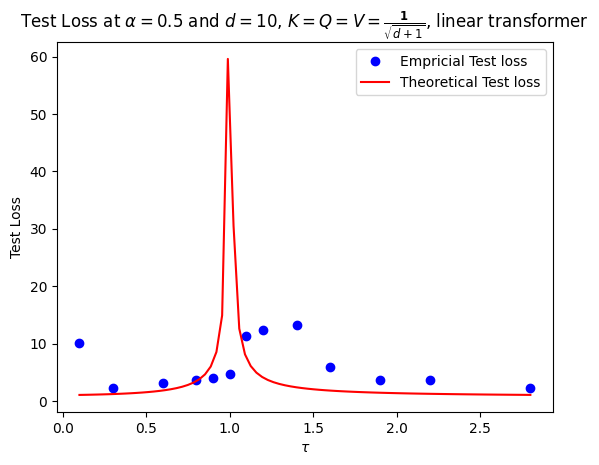

In [9]:
# Compute theoretical test loss or generalization error

t_list = np.linspace(0.1, 2.8, num=80)
t_array = np.zeros(len(t_list))

for t in range(len(t_list)):
  t_array[t] = TheoryTestLoss(0.1, 1, 0.5, t_list[t])

# Plot empirical test loss vs theoretical generalization error

plt.figure(1)
plt.plot(tau_list, test_loss_list, linestyle='', marker='o', color='b', label='Empricial Test loss')
plt.plot(t_list, t_array, color='r', label='Theoretical Test loss')
plt.title(r'Test Loss at $\alpha=0.5$ and $d=10$, $K=Q=V=\frac{\mathbf{1}}{\sqrt{d+1}}$, linear transformer')
plt.xlabel(r'$\tau$')
plt.ylabel('Test Loss')
plt.legend()
plt.show()



#**Comment: If you increase token dimension, e.g. $d=2000$ or $d=500$ at home / cluster, you will see a good match between theory and empirical generalization errors. This is because sequence length $l$ also increase in proportion, while sample size $p$ increases quadratically. Please feel free to play with the token dimension. This exaplains why Linearized Transformers (extrapolating this to real life nonlinear transformers) generalize so well when trained over large data.**